In [30]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [31]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(15)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [32]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [33]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [34]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        # self.u_scale = torch.sqrt(torch.mean(u_train**2))
        self.u_scale = torch.max(torch.abs(u_train))
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func) 
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train) * self.loss_scale
            loss_value.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train) * self.loss_scale
        loss_value.backward()
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
            self._adam_train(n_iter)
        elif method == 2:
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.1, max_iter=n_iter//3, tolerance_grad=1e-11, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [35]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

In [36]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(5000, 1)
model1.train(1000, 2)
u_p = model1.predict(x_eval)

Iteration 0, Loss: 0.8123141342565481
Iteration 100, Loss: 0.08000975461676445
Iteration 200, Loss: 0.011722769534832912
Iteration 300, Loss: 0.003394520930290405
Iteration 400, Loss: 0.0026526228202103127
Iteration 500, Loss: 0.0021618500782923386
Iteration 600, Loss: 0.0018237744345992793
Iteration 700, Loss: 0.0015819289239924143
Iteration 800, Loss: 0.0013997334662830842
Iteration 900, Loss: 0.0012543273411228257
Iteration 1000, Loss: 0.001131632566158676
Iteration 1100, Loss: 0.0010229569838804855
Iteration 1200, Loss: 0.0009227891842305204
Iteration 1300, Loss: 0.0008274083390963343
Iteration 1400, Loss: 0.0007340382102444378
Iteration 1500, Loss: 0.0006403891696877796
Iteration 1600, Loss: 0.0005445611846760742
Iteration 1700, Loss: 0.0004454392235296434
Iteration 1800, Loss: 0.00034381559851917815
Iteration 1900, Loss: 0.00024411007231319983
Iteration 2000, Loss: 0.00015509271823501965
Iteration 2100, Loss: 8.663699879121109e-05
Iteration 2200, Loss: 4.301229032778185e-05
Itera

In [37]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train).detach()
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(10000, 1)
model2.train(1000, 2)
u_pred2 = model2.predict(x_eval)
u_p2 = u_p + u_pred2

Iteration 0, Loss: 6.911963379072536e-06
Iteration 100, Loss: 2.150895055566067e-08
Iteration 200, Loss: 6.2589066908365635e-09
Iteration 300, Loss: 2.2580284677352497e-09
Iteration 400, Loss: 1.1779908186053186e-09
Iteration 500, Loss: 7.776579149412096e-10
Iteration 600, Loss: 5.615047721900924e-10
Iteration 700, Loss: 4.2346389587068125e-10
Iteration 800, Loss: 3.2994842530498263e-10
Iteration 900, Loss: 2.642408819001648e-10
Iteration 1000, Loss: 2.163932180646486e-10
Iteration 1100, Loss: 1.80319320845262e-10
Iteration 1200, Loss: 1.5230200532592663e-10
Iteration 1300, Loss: 1.300566232787908e-10
Iteration 1400, Loss: 1.1214088391035793e-10
Iteration 1500, Loss: 9.759554980364984e-11
Iteration 1600, Loss: 8.573561707451194e-11
Iteration 1700, Loss: 7.603612329262029e-11
Iteration 1800, Loss: 6.807430062970097e-11
Iteration 1900, Loss: 6.150237512711119e-11
Iteration 2000, Loss: 5.603472879758042e-11
Iteration 2100, Loss: 5.144021621990132e-11
Iteration 2200, Loss: 4.75353681801524

In [38]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach()
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(30000, 1)
model3.train(1000, 2)
u_pred3 = model3.predict(x_eval)
u_p3 = u_p2 + u_pred3

Iteration 0, Loss: 1.568783650330439e-10
Iteration 100, Loss: 1.253822370491093e-10
Iteration 200, Loss: 9.688648874825809e-11
Iteration 300, Loss: 4.8852983471179126e-11
Iteration 400, Loss: 3.19766549324174e-11
Iteration 500, Loss: 2.637007511346221e-11
Iteration 600, Loss: 2.2052226484420557e-11
Iteration 700, Loss: 1.89707985885227e-11
Iteration 800, Loss: 1.6990455822123242e-11
Iteration 900, Loss: 1.575053415023921e-11
Iteration 1000, Loss: 1.492364378958167e-11
Iteration 1100, Loss: 1.431147109014492e-11
Iteration 1200, Loss: 1.381311895569932e-11
Iteration 1300, Loss: 1.3379617297745434e-11
Iteration 1400, Loss: 1.2986641285539968e-11
Iteration 1500, Loss: 1.2621382211648534e-11
Iteration 1600, Loss: 1.227660761802695e-11
Iteration 1700, Loss: 1.1947970354892416e-11
Iteration 1800, Loss: 1.163274565328274e-11
Iteration 1900, Loss: 1.1329198359196533e-11
Iteration 2000, Loss: 1.1036233700006382e-11
Iteration 2100, Loss: 1.0753181062411054e-11
Iteration 2200, Loss: 1.047964614221

In [39]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(40000, 1)
model4.train(1000, 2)
u_pred4 = model4.predict(x_eval)

u_p4 = u_p3 + u_pred4

Iteration 0, Loss: 6.272287524551752e-11
Iteration 100, Loss: 4.2433441856452336e-11
Iteration 200, Loss: 3.304291066204518e-11
Iteration 300, Loss: 2.7846257422447476e-11
Iteration 400, Loss: 2.4907591170961094e-11
Iteration 500, Loss: 2.3131904833727853e-11
Iteration 600, Loss: 2.178304944142237e-11
Iteration 700, Loss: 2.058554719604865e-11
Iteration 800, Loss: 1.945700025988806e-11
Iteration 900, Loss: 1.8401556272535134e-11
Iteration 1000, Loss: 1.7445402609483588e-11
Iteration 1100, Loss: 1.659733710469341e-11
Iteration 1200, Loss: 1.5848316719248344e-11
Iteration 1300, Loss: 1.5183472506614366e-11
Iteration 1400, Loss: 1.4589775926322052e-11
Iteration 1500, Loss: 1.4058604903499674e-11
Iteration 1600, Loss: 1.3584969076543512e-11
Iteration 1700, Loss: 1.3165368246293129e-11
Iteration 1800, Loss: 1.2796081548977952e-11
Iteration 1900, Loss: 1.2472534786417342e-11
Iteration 2000, Loss: 1.2189378621327704e-11
Iteration 2100, Loss: 1.194080351452055e-11
Iteration 2200, Loss: 1.17209

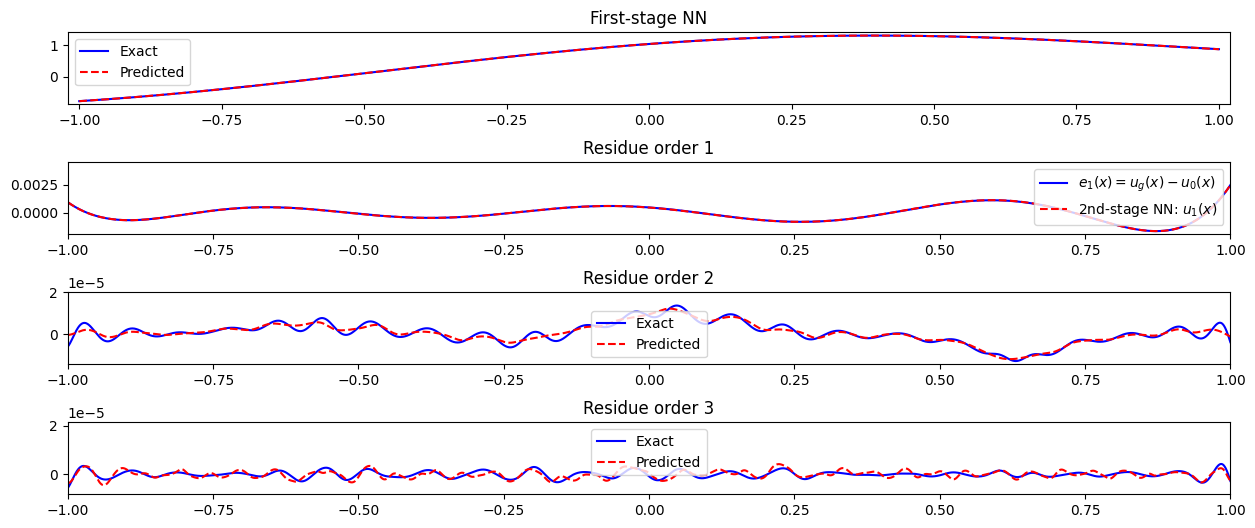

In [40]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_p.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train, u_train2.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval, u_pred2.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening, u_train3, 'b-', label='Exact')
axes[2].plot(x_eval, u_pred3.detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening, u_train4.detach(), 'b-', label='Exact')
axes[3].plot(x_eval, u_pred4.detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [41]:
import numpy as np 
error_u = np.linalg.norm(u_eval - u_p.detach())/np.linalg.norm(u_eval, 2)
error_u2 = np.linalg.norm(u_eval - u_p2.detach())/np.linalg.norm(u_eval, 2)
error_u3 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)
error_u4 = np.linalg.norm(u_eval - u_p4.detach())/np.linalg.norm(u_eval, 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0007016672840061439
Error of order 2: 5.325743823131867e-06
Error of order 3: 1.4191234986722987e-06
Error of order 4: 1.2098523867915607e-06
